In [1]:
# ch3/ch3_6_spark/spark_mllib.ipynb
# 标准库
import sys
import time

# 第三方库
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, monotonically_increasing_id
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# 自定义模块
sys.path.append('./../../')
import utils.dataset_spark as d
import utils.metrics_spark as m
import utils.plot as p

# 绘图参数
name_var = 'PM2.5浓度'
name_unit = ' ($\mu g/m^3$)'
p.set_matplotlib(plot_dpi=80, save_dpi=600, font_size=12)


In [2]:
# 创建Spark Session
spark = SparkSession\
    .builder\
    .master('local[*]')\
    .appName('Time Series Forecasting')\
    .getOrCreate()

# 允许Spark直接输出显示Dataframe
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

# 允许最大显示行数
spark.conf.set('spark.sql.repl.eagerEval.maxNumRows', 10)


22/12/20 17:27:12 WARN Utils: Your hostname, yeli-workstation resolves to a loopback address: 127.0.1.1; using 192.168.3.126 instead (on interface wlp6s0)
22/12/20 17:27:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/12/20 17:27:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# 数据读取和统计分析
data = spark.read.csv('./../data/data_pm2_5.csv',
                      header='true', inferSchema='true')
data = data.withColumn('id', monotonically_increasing_id())
data.show(5, truncate=False)


+-------------------+-----+---+
|Datetime           |PM2_5|id |
+-------------------+-----+---+
|2021-09-01 00:00:00|9.0  |0  |
|2021-09-01 01:00:00|9.0  |1  |
|2021-09-01 02:00:00|10.0 |2  |
|2021-09-01 03:00:00|12.0 |3  |
|2021-09-01 04:00:00|13.0 |4  |
+-------------------+-----+---+
only showing top 5 rows



In [4]:
# 监督学习样本构建
H = 5
dataset = d.moving_window(data, H, ['PM2_5'])
dataset = dataset\
    .filter(col('id') >= H)\
    .select(
        (col('id')-H+1).alias('id'),
        col('features'),
        col('var0').alias('label')
    )

dataset.show(5, truncate=False)

# 训练测试样本划分
ratio_train = 0.7  # 训练样本比例
num_train = int(data.count()*ratio_train)  # 训练样本数量
train = dataset.filter(col('id') <= num_train-H)
test = dataset.filter(col('id') > num_train-H)
print(f'{train.count()=}, {test.count()=}')


22/12/20 17:27:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:27:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:27:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+---+--------------------------+-----+
|id |features                  |label|
+---+--------------------------+-----+
|1  |[13.0,12.0,10.0,9.0,9.0]  |14.0 |
|2  |[14.0,13.0,12.0,10.0,9.0] |16.0 |
|3  |[16.0,14.0,13.0,12.0,10.0]|20.0 |
|4  |[20.0,16.0,14.0,13.0,12.0]|33.0 |
|5  |[33.0,20.0,16.0,14.0,13.0]|34.0 |
+---+--------------------------+-----+
only showing top 5 rows

train.count()=498, test.count()=217


In [5]:
# 模型定义
models = {
    'MLR':  LinearRegression(),
    'DT':  DecisionTreeRegressor(),
    'RF':  RandomForestRegressor(),
    'GBRT': GBTRegressor()
}

# 网格参数定义
all_grids = {
    'MLR': ParamGridBuilder()
    .addGrid(models['MLR'].maxIter, [100, 200, 300, 400, 500])
    .addGrid(models['MLR'].regParam, [0.1, 0.01, 0.001])
    .addGrid(models['MLR'].elasticNetParam, [0.1*i for i in range(1, 11)])
    .build(),

    'DT':  ParamGridBuilder()
    .addGrid(models['DT'].maxDepth, [10, 20, 30])
    .addGrid(models['DT'].maxBins, [8, 16, 32])
    .addGrid(models['DT'].minInstancesPerNode, [1, 2, 3])
    .addGrid(models['DT'].minInfoGain, [1, 0.1, 0.01])
    .build(),

    'RF': ParamGridBuilder()
    .addGrid(models['RF'].maxDepth, [10, 20, 30])
    .addGrid(models['RF'].maxBins, [8, 16, 32])
    .addGrid(models['RF'].minInstancesPerNode, [1, 2, 3])
    .addGrid(models['RF'].minInfoGain, [1, 0.1, 0.01])
    .build(),

    'GBRT': ParamGridBuilder()
    .addGrid(models['GBRT'].maxDepth, [10, 20, 30])
    .addGrid(models['GBRT'].maxBins, [8, 16, 32])
    .addGrid(models['GBRT'].minInstancesPerNode, [1, 2, 3])
    .addGrid(models['GBRT'].minInfoGain, [1, 0.1, 0.01])
    .build()
}

# 存储各模型预测结果
all_times = []
all_predictions = []

# 训练测试各模型
for name_model, estimator in models.items():

    # 交叉验证
    cv_estimator = CrossValidator(
        estimator=estimator,
        estimatorParamMaps=all_grids[name_model],
        evaluator=RegressionEvaluator(metricName='mse'),
        numFolds=5,
        parallelism=4  # 若负荷过高或内存溢出可适当降低本参数
    )

    # 训练集-训练
    tic = time.time()
    model = cv_estimator.fit(train)
    toc = time.time() - tic

    # 测试集-测试
    predictions = model.transform(test)

    # 测试集-误差计算
    print(f'模型:{name_model}训练完成, 用时:{toc:.3f}s')
    all_times.append(toc)
    all_predictions.append(predictions)


22/12/20 17:27:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:27:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:27:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:27:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:27:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:27:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 1

模型:MLR训练完成, 用时:34.553s


22/12/20 17:27:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:27:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:27:54 WARN BlockManager: Block rdd_26441_0 already exists on this machine; not re-adding it
22/12/20 17:27:54 WARN BlockManager: Block rdd_26441_0 already exists on this machine; not re-adding it
22/12/20 17:28:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:28:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:28:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause 

模型:DT训练完成, 用时:46.396s


22/12/20 17:28:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:28:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:28:49 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB
22/12/20 17:28:50 WARN DAGScheduler: Broadcasting large task binary with size 1057.0 KiB
22/12/20 17:28:50 WARN DAGScheduler: Broadcasting large task binary with size 1089.3 KiB
22/12/20 17:28:56 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB
22/12/20 17:28:56 WARN DAGScheduler: Broadcasting large task binary with size 1057.0 KiB
22/12/20 17:28:56 WARN DAGScheduler: Broadcasting large task binary with size 1089.3 KiB
22/12/20 17:28:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause seri

模型:RF训练完成, 用时:84.573s


22/12/20 17:30:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:30:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:30:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:30:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:31:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:31:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 1

模型:GBRT训练完成, 用时:222.629s


模型:MLR


22/12/20 17:33:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 1

mse=12.863
rmse=3.587
mae=2.574
r2=0.873


22/12/20 17:33:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


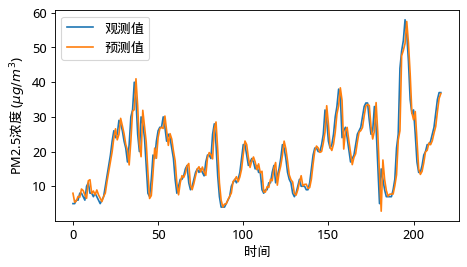

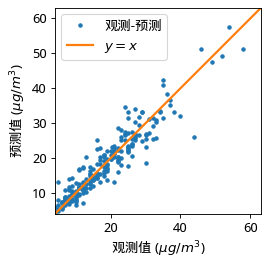

模型:DT


22/12/20 17:33:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 1

mse=17.958
rmse=4.238
mae=3.068
r2=0.822


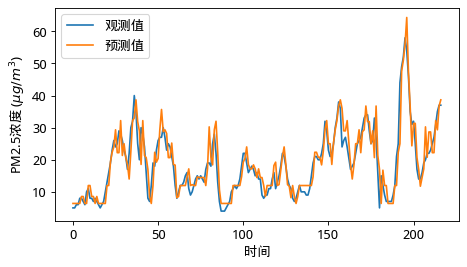

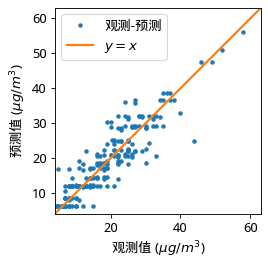

模型:RF


22/12/20 17:33:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 1

mse=16.820
rmse=4.101
mae=2.968
r2=0.834


22/12/20 17:33:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


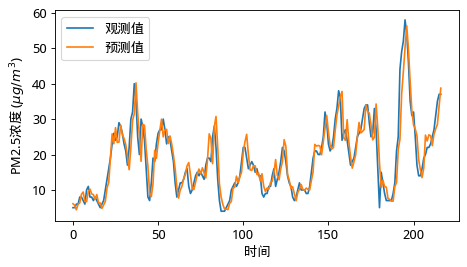

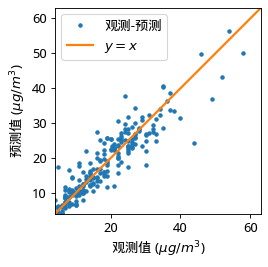

模型:GBRT


22/12/20 17:33:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 1

mse=17.958
rmse=4.238
mae=3.068
r2=0.822


22/12/20 17:33:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/20 17:33:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


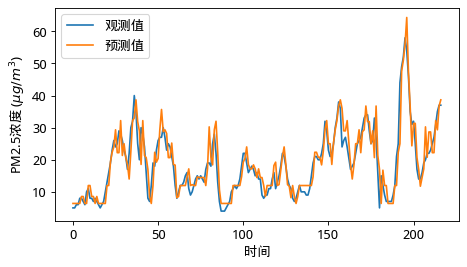

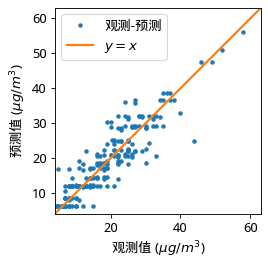

In [6]:
# 测试集-误差计算
for name_model, predictions in zip(models.keys(), all_predictions):

    print(f'模型:{name_model}')
    m.all_metrics_spark(predictions)

    pred = predictions.toPandas()
    p.plot_results(
        y_true=pred['label'],
        y_pred=pred['prediction'],
        xlabel='时间',
        ylabel=f'{name_var}{name_unit}',
        fig_name=f'{name_model}_预测曲线'
    )
    p.plot_parity(
        y_true=pred['label'],
        y_pred=pred['prediction'],
        xlabel=f'观测值{name_unit}',
        ylabel=f'预测值{name_unit}',
        fig_name=f'{name_model}_Parity'
    )


In [7]:
# 停止spark
spark.stop()